<a href="https://colab.research.google.com/github/ThiagSampaio/DeepLearning/blob/main/Classifica%C3%A7%C3%A3o_de_dados_planos_com_uma_camada_oculta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de dados planos com uma camada oculta.

No final desde material, teremos a capacidade de:

- Implementar uma rede neural de 2 classe com uma única camada escondida
- Usar neurônios com uma função não linear como ativação, como a função tangente hiperbólica
- Calcular a perda de entropia
- Implementar a progação direta e reversa




## Table of Contents
- [1 - Pacotes](#1)
- [2 - Carregando os dados](#2)
    - [Demonstração 1](#ex-1)
- [3 - Simple Logistic Regression](#3)
- [4 - Modelo Rede Neural](#4)
    - [4.1 - Definindo a estrutura da rede neural](#4-1)
        - [Demonstração 2 - tamanho das camadas](#ex-2)
    - [4.2 - Initialize the model's parameters](#4-2)
        - [Demonstração 3 - initialize_parameters](#ex-3)
    - [4.3 - The Loop](#4-3)
        - [Demonstração 4 - propagação direta](#ex-4)
    - [4.4 - Calculando o custo](#4-4)
        - [Demonstração 5 - compute_cost](#ex-5)
    - [4.5 - Implementando a propagação reversa](#4-5)
        - [Demonstração 6 - backward_propagation](#ex-6)
    - [4.6 - Atualizando parametros](#4-6)
        - [Demonstração 7 - update_parameters](#ex-7)
    - [4.7 - Integration](#4-7)
        - [Demonstração 8 - nn_model](#ex-8)
- [5 - Testando o modelos](#5)
    - [5.1 - Prevendo](#5-1)
        - [Demonstração 9 - Prevendo](#ex-9)
    - [5.2 - Teste o modelo no conjunto de dados planar](#5-2)
- [6 - Ajustando o tamanho da camada oculta ](#6)


<a name='1'></a>
# 1 - Pacotes

Primeiro, importamos todos os pacotes que iremos utilizar durante essa demonstração.

- [numpy](https://www.numpy.org/) é o pacote fundamental para computação científica com Python.
- [sklearn](http://scikit-learn.org/stable/) fornece ferramentas simples e eficientes para mineração de dados e análise de dados.
- [matplotlib](http://matplotlib.org) é uma biblioteca para traçar gráficos em Python.
- testCases fornece alguns exemplos de teste para avaliar a exatidão de suas funções
- planar_utils fornecem várias funções úteis usadas nesta demonstração


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
from public_tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(2)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
# 2 - Carregando os dados

Agora, vamos carregar os dados que iremos trabalhar.

In [29]:
X, Y = load_planar_dataset()

Vamos vizualizar os dados usando matplotlib. Os dados parecem uma flor com alguns pontos vermelhos(y=0) e alguns pontos azuis(y=1). Nosso objetivo é construir um modelo que aprenda com esses dados. Em outras palavras, nós queremos uma classificador que define as regiões sendo vermelho ou azul.

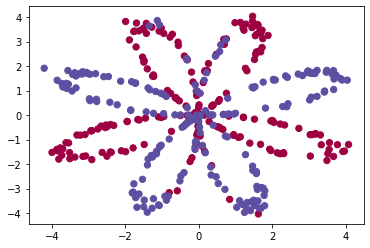

In [30]:
#Visualizando os dados:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Temos:

- uma array-numpy (matriz) X que contém as características (x1, x2)
- uma array-numpy (vector) Y que contém os rótulos(red:0, blue:1).

Primeiro vamos ter uma melhor compreensão o que os dados parecem:

<a name='ex-1'></a>
### Demonstração 1 

Primeiro approach com os dados:

In [31]:
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]

print('O shape de X é: ' + str(shape_X))
print('O shape de Y é: ' + str(shape_Y))
print('Temos m = %d exemplos de treino!' % (m))

O shape de X é: (2, 400)
O shape de Y é: (1, 400)
Temos m = 400 exemplos de treino!


<a name='3'></a>
## 3 - Regressão Logistica Simples

Antes de contruir uma rede neural, vamos checar como a regressão logistica performa neste problema. Podemos usar as funções sklearn's.

In [32]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisão da regressão logistica: 47 % (% de dados corretamente previstos)


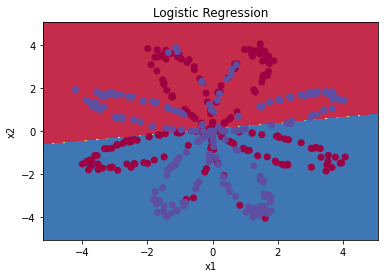

In [33]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Precisão da regressão logistica: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(% de dados corretamente previstos)")

**Interpretação**: Os dados não são linearmene separados, então a regressão logística não tem uma boa performace. Vamos utilizar uma rede neural. 

<a name='4'></a>
## 4 - Modelo Rede Neural

Regressão logística não trabalhou bem para esse conjunto de dados. Vamos treinar uma rede neural com uma únida camada escondida e ver como ela lida com o problema 

**O Modelo**:
![](https://drive.google.com/uc?export=view&id=1L0SzRg4WZE_dGX6RWWomQXS8pl06AlPX)

**Matematicamente**:

Para um exemplo: $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Dados as previões de todos os exemplos, podemos calcular o custo $J$ seguindo: 

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Lembre-se**: O método geral para construir uma rede neural é:

    1. Definir a estrutura da rede neural ( #número de inputs,  #número de camadas, etc). 
    2. Inicializar os parâmetros do modelo
    3. Loop:
        - Implementar a propagação direta
        - Calcular a perda
        - Implementar a propagação reversa e pegar os gradientes
        - atualizar os parâmetros (gradiente descendente)

Na prática, vamos sempre constuir funções para calcular os passos 1-3, para junta-lás em uma função chamada `nn_model()`.
Uma vez que foi construído `nn_model()` e aprendido os parâmetros corretamente, podemos fazer previsões em novos dados 


<a name='4-1'></a>
### 4.1 - Definindo a estrutura da rede neural ####

<a name='ex-2'></a>
### Exercise 2 - tamanho das camadas

Definiremos três variáveis :

    - n_x: o tamanho da camada de input
    - n_h: o tamanho da camada escondida (set this to 4) 
    - n_y: o tamanho da camada de saida

In [34]:
def layer_sizes(X, Y):
  """
  Argumentos:
  X -- dados de input de tamanho (tamanho do input, número de exemplos)
  Y -- rótulos de tamanho(tamanho da saída, número de exemplos)

  Retorna:
  n_x -- o tamanho da camada de input
  n_h -- tamanho da camada escondida
  n_y -- tamango da camada de saída
  """

  n_x = X.shape[0]
  n_h = 4
  n_y = Y.shape[0]

  return (n_x, n_h, n_y)

In [35]:
t_X, t_Y = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(t_X, t_Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

layer_sizes_test(layer_sizes)

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
 All tests passed.


<a name='4-2'></a>
### 4.2 - Inicializando os parâmetros do modelo ####

<a name='ex-3'></a>
### Demonstração 3 -  initialize_parameters

In [36]:
def initialize_parameters(n_x, n_h, n_y):
  """
  Argumentos:
  n_x -- tamanho da camada de input
  n_h -- tamanho da camada escondida
  n_y -- tamanho da camada de saída

  Retorna:
  params -- um dicionário python contendo os parâmentros:
                W1 -- matriz de pesos de dimensão (n_h, n_x)
                b1 -- vetor de viés com a dimensão (n_h, 1)
                W2 -- matriz de pesos de dimensão (n_y, n_h)
                b2 -- vetor de viés com a dimensão (n_y, 1)

  """
  np.random.seed(2)

  W1 = np.random.randn(n_h, n_x) * 0.01
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_y, n_h) * 0.01
  b2 = np.zeros((n_y,1))

  parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
  return parameters

In [37]:
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

initialize_parameters_test(initialize_parameters)

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
 All tests passed.


<a name='4-3'></a>
### 4.3 - O Loop

<a name='ex-4'></a>
### Demonstração 4 - Propagação direta

Vamos implementar a função `forward_propation()` usando as seguintes equações:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$



In [38]:
def forward_propagation(X, parameters):
  """
  Argumentos:
  X -- dados de entrada de tamanho (n_x, m)
  parameters -- dicionário pyhton contendo seus parâmentros (saída da função de inicialização)

  Retorna:
  A2 -- O output da função sigmoid da segunda ativação
  cache -- dicionário contendo "Z1", "A1", "Z2" e "A2"
  """
  #Pegar os valores dos parâmetros do dicionário "parameters"

  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"] 

  #Implementação da Propagação direta para calcular A2 (probabilidades)

  Z1 = np.dot(W1,X) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2,A1) + b2
  A2 = sigmoid(Z2)

  assert(A2.shape == (1, X.shape[1]))
    
  cache = {"Z1": Z1,
           "A1": A1,
           "Z2": Z2,
           "A2": A2}

  return A2, cache         

In [39]:
t_X, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(t_X, parameters)
print("A2 = " + str(A2))

forward_propagation_test(forward_propagation)

A2 = [[0.21292656 0.21274673 0.21295976]]
 All tests passed.


<a name='4-4'></a>
### 4.4 - Calculando o custo

Agora que calculamos $A^{[2]}$ (in the Python variable "`A2`"), que contém $a^{[2](i)}$ para todos os exemplos, podemos calcular a função custo abaixo:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

<a name='ex-5'></a>
### Demonstração 5 - função custo


In [40]:
def compute_cost(A2, Y):
  """
  Calcula a entropia cruzada do custo dado a equação (13)

  Argumentos:
  A2 -- A função de saída sigmoid da segunda ativação, de tamanho(1, número de exemplos)
  Y -- "verdadeiros" valores. Vetor de dimansão (1, número de exemplos)

  Retorna
  cost -- Entropia cruzada do custo dado a equação (13)
  """
  m = Y.shape[1]

  # Calculo da entropia

  logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2),1 - Y)
  cost = -(1/m)* np.sum(logprobs)

  # Tendo a certeza que possui a dimensão que esperamos
  # E.x., transdorma [[17]] em 17

  cost = float(np.squeeze(cost)) 

  return cost

In [41]:
A2, t_Y = compute_cost_test_case()
cost = compute_cost(A2, t_Y)
print("cost = " + str(compute_cost(A2, t_Y)))

compute_cost_test(compute_cost)

cost = 0.6930587610394646
 All tests passed.


<a name='4-5'></a>
### 4.5 - Implementação da propagação reversa

Usando os valores cache achados durante a propagação direta, podemos implementar a propagação reversa

<a name='ex-6'></a>
### Demonstração 6 -  backward_propagation

Vamos implementar a função `backward_propagation()`.

** Instruções **:

A retropropagação geralmente é a parte mais difícil (mais matemática) do aprendizado profundo. Para nos ajudar, abaixo está as seis equações que vamos utilizar.

![](https://drive.google.com/uc?export=view&id=1_aTtJVz0L_5oLN9rRXSsvu0s4dxc0uBQ)


In [42]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implementando a propagação reversa usando as instruções acima
    
    Arguments:
    parameters -- dicionário python contendo os parâmetros
    cache -- dicionário contendo "Z1", "A1", "Z2" and "A2".
    X -- dados de input com o tamanho (2, numero de exemplos)
    Y -- vetor de "true" labels de tamanho (1, number of examples)
    
    Returns:
    grads -- dicionario python contendo os gradientes ligados com cada parâmetro
    """
    m = X.shape[1]
    
    # Primeiro carregamos os parâmetros W1 e W2
    W1 = parameters["W1"]
    W2 = parameters["W2"]   
        
    # Carregamos também os valores de A1 e A2
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Propagação reversa: Calculo de dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2,A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1,X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [43]:
parameters, cache, t_X, t_Y = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, t_X, t_Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

backward_propagation_test(backward_propagation)

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]
 All tests passed.


<a name='4-6'></a>
### 4.6 - Atualização dos Parâmetros

<a name='ex-7'></a>
### Demonstração 7:

Vamos implementar a regra de atualização usando o gradiente descendente. Teremos que usar (dW1, db1, dW2, db2) para atualizar (W1, b1, W2, b2).

**Regra geral do gradiente desncente**: $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ onde $\alpha$ é a taxa de aprendizado and $\theta$ representa o parâmetro.

![](https://drive.google.com/uc?export=view&id=180NZPeNMOCw4YBJsggDfwyR4-Ob3lxKZ)

![](https://drive.google.com/uc?export=view&id=1RO0RqMjVDjSULhTpW2lr1XpxhHiOwVfo)
<caption><center><font color='purple'><b>Figura 2</b>:Gradiente descendente com um bom valor de aprendizado(converge) e um ruim valor de aprendizado(diverge)</font></center></caption>



In [44]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Atualiza os parametros usando gradiente descendente mostrado acima
    
    Arguments:
    parameters -- dicionário python contendo os parâmetros
    grads -- dicionário python contendo os gradientes
    
    Retorna:
    parameters -- dicionário python contendo meus parâmetros atualizados
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    
    # Regra de atualização de cada parâmetro
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [45]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

update_parameters_test(update_parameters)

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
 All tests passed.


<a name='4-7'></a>
### 4.7 - Integração

Vamos integrar todas as funções em uma chamada `nn_model()` 

<a name='ex-8'></a>
### Demonstração 8 - nn_model

In [46]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dados de tamanho (2, number e número de exemplos)
    Y -- respostas de tamango(1, numero de exemplos)
    n_h -- tamanho da camada escondida
    num_iterations -- Número de iterações do gradiente descendente
    print_cost -- se for verdadeiro, imprime o custo a cada 1000 iterações
    
    Returns:
    parameters -- parâmetros aprendidos pelo modelo. Eles podem então ser usados ​​para prever.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Inicializando Parâmetros
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradiente descendente)

    for i in range(0, num_iterations):
         
        #(≈ 4 lines of code)
        # Propagação direta. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        cost = compute_cost(A2, Y)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)
        

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [47]:
t_X, t_Y = nn_model_test_case()
parameters = nn_model(t_X, t_Y, 4, num_iterations=10000, print_cost=True)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

nn_model_test(nn_model)

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]
 All tests passed.


<a name='5'></a>
## 5 - Testando o modelo

<a name='5-1'></a>
### 5.1 - Previsão

<a name='ex-9'></a>
### Demonstração 9 - predict

Vamos fazer uma previsão construindo uma função `predict`. Usando a propagação direta para prever os resultados


In [48]:

def predict(parameters, X):
    """
    Usando os parâmetros aprendidos, prevê uma classe para cada exemplo em X
    
    Argumentos:
    parâmetros - dicionário python contendo seus parâmetros
    X - dados de entrada de tamanho (n_x, m)
    
    Devoluções
    previsões - vetor de previsões do nosso modelo (vermelho: 0 / azul: 1)
    """
    
    A2, cache = forward_propagation(X,parameters)
    predictions = (A2 > 0.5)
    
    
    return predictions

In [49]:
parameters, t_X = predict_test_case()

predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))

predict_test(predict)

Predictions: [[ True False  True]]
 All tests passed.


<a name='5-2'> </a>
### 5.2 - Teste o modelo no conjunto de dados planar

É hora de executar o modelo e ver como ele funciona em um conjunto de dados planar. Execute o seguinte código para testar seu modelo com uma única camada oculta de $ n_h $ unidades ocultas!

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219455
Cost after iteration 9000: 0.218607


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

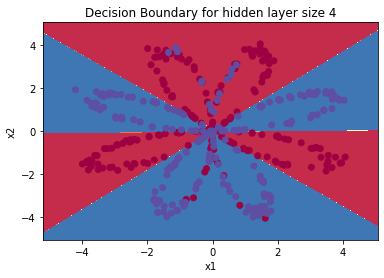

In [50]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [51]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%



A precisão é muito alta em comparação com a regressão logística. A modelo aprendeu os padrões das pétalas da flor! Ao contrário da regressão logística, as redes neurais são capazes de aprender até mesmo limites de decisão altamente não lineares.

<a name='6'> </a>
## 6 - Ajustando o tamanho da camada oculta 

Execute o código a seguir (pode levar de 1 a 2 minutos). Em seguida, observe os diferentes comportamentos do modelo para vários tamanhos de camadas ocultas.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.25 %


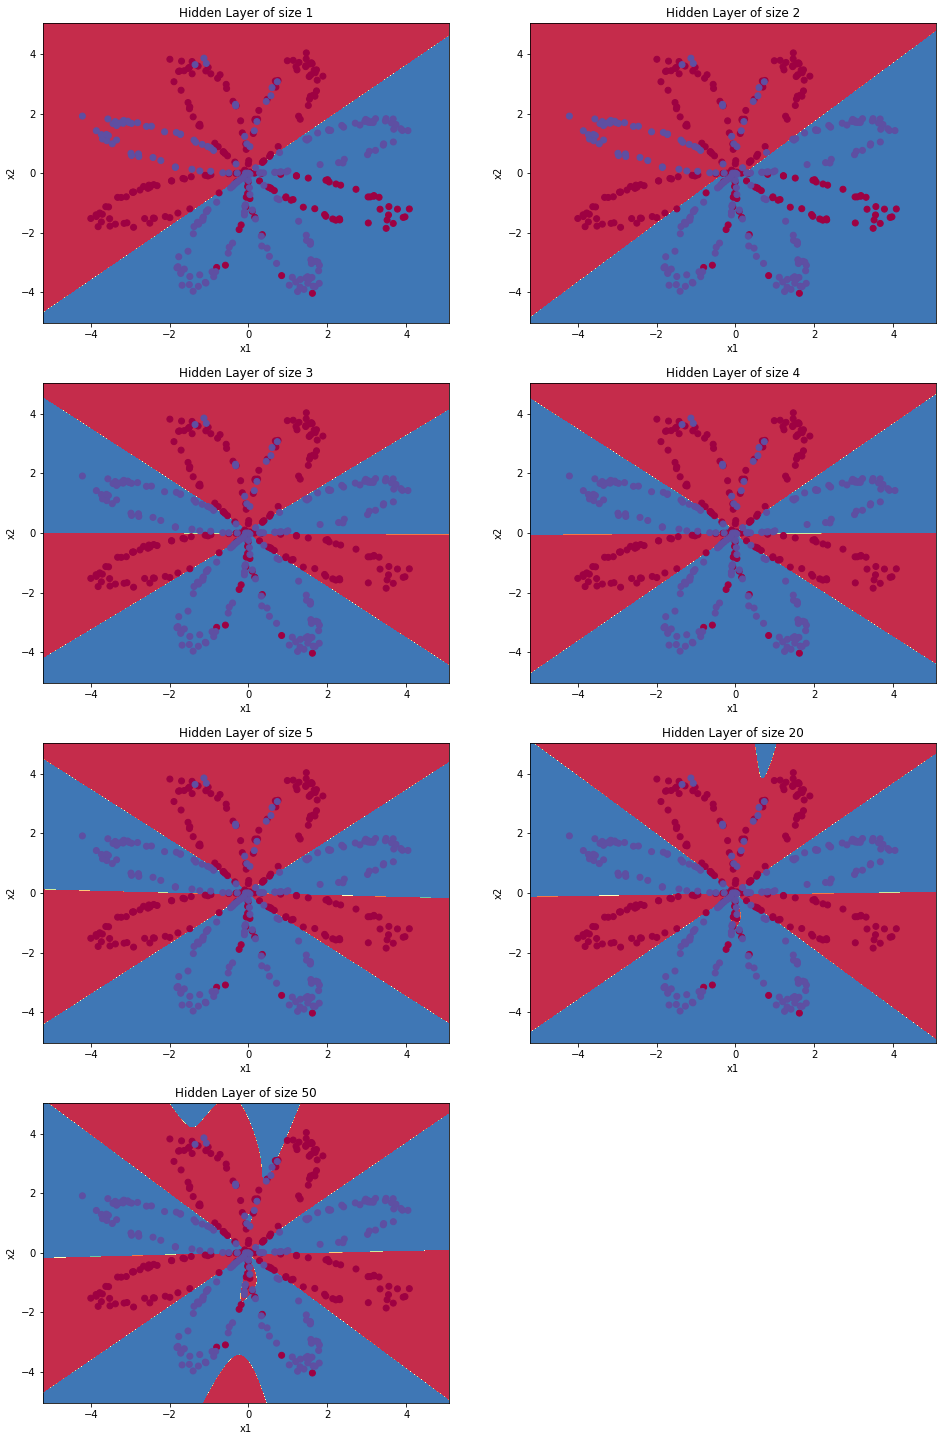

In [52]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretação**:
- Os modelos maiores (com mais unidades ocultas) são capazes de se ajustar melhor ao conjunto de treinamento, até que eventualmente os modelos maiores se ajustem aos dados.
- O melhor tamanho de camada oculta parece estar em torno de n_h = 5. Na verdade, um valor por aqui parece se adequar bem aos dados, sem também incorrer em overfitting perceptível.
